In [4]:
#numeric: pandas and numpy
import numpy as np
import pandas as pd
# graphics
%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 

In [5]:
from sklearn.datasets import make_blobs, make_circles, make_moons, make_circles

X_blobs, y_blobs = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=None)

X_moon,y_moon= make_moons(n_samples=1000, shuffle=True, noise=None, random_state=None)

X_cir, y_cir= make_circles(n_samples=1000, shuffle=True, noise=None, random_state=None, factor=0.4)

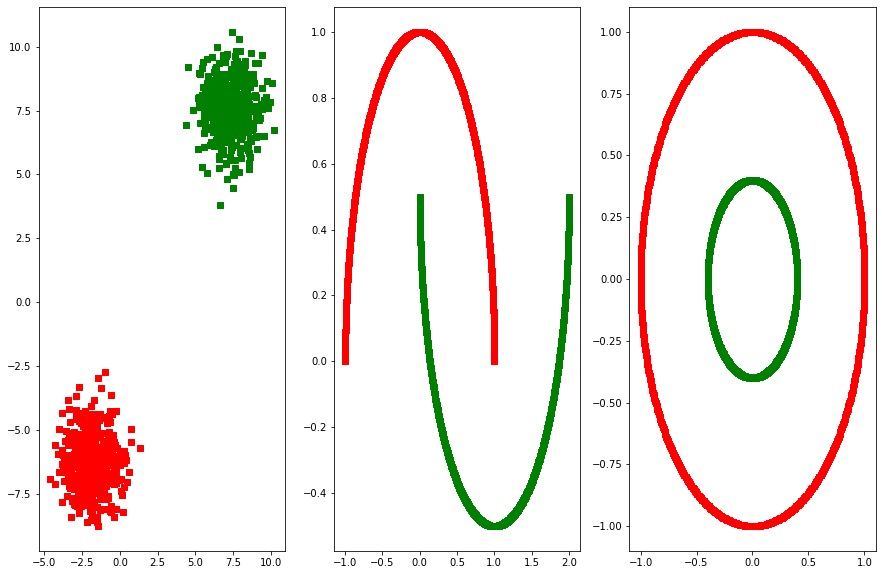

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))

ax1.scatter(X_blobs[y_blobs==0,0],X_blobs[y_blobs==0,1],marker='s',color='r',label='0' )
ax1.scatter(X_blobs[y_blobs==1,0],X_blobs[y_blobs==1,1],marker='s',color='g',label='0' )
#ax1.set_aspect('equal')
ax2.scatter(X_moon[y_moon==0,0],X_moon[y_moon==0,1],marker='s',color='r',label='0' )
ax2.scatter(X_moon[y_moon==1,0],X_moon[y_moon==1,1],marker='s',color='g',label='0' )

ax3.scatter(X_cir[y_cir==0,0],X_cir[y_cir==0,1],marker='s',color='r',label='0' )
ax3.scatter(X_cir[y_cir==1,0],X_cir[y_cir==1,1],marker='s',color='g',label='0' )

In [7]:
from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import cross_validate, GridSearchCV

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_blobs,y_blobs, test_size=0.2, random_state=44, stratify=y_blobs)

In [9]:
print("Training set feature matrix shape: " + str(x_train.shape))
print("Training set classification matrix shape: " + str(y_train.shape))
print("Testing set feature matrix shape: " + str(x_test.shape))
print("Testing set classification matrix shape: " + str(y_test.shape))
print("------------------------------------------------")

Training set feature matrix shape: (800, 2)
Training set classification matrix shape: (800,)
Testing set feature matrix shape: (200, 2)
Testing set classification matrix shape: (200,)
------------------------------------------------


In [10]:
#print(x_train[0])
#print(y_train)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 400, 1: 400}


## SVM (Linear) vs SVM (RBF)

In [11]:

svmRBF = svm.SVC(kernel='rbf')

svmRBF.fit(x_train, y_train)

print("train accuracy: {} ".format(svmRBF.score(x_train, y_train)))
print("test accuracy: {} ".format(svmRBF.score(x_test, y_test)))


train accuracy: 1.0 
test accuracy: 1.0 


In [12]:

svmLinear = svm.SVC(kernel='linear')

svmLinear.fit(x_train, y_train)

print("train accuracy: {} ".format(svmLinear.score(x_train, y_train)))
print("test accuracy: {} ".format(svmLinear.score(x_test, y_test)))

train accuracy: 1.0 
test accuracy: 1.0 


In [13]:
svmRBF = svm.SVC(kernel='rbf')
svmLinear = svm.SVC(kernel='linear')

In [14]:
def compare_matrices(correct_values, model1_values, model2_values):
    model1_correct = np.array(correct_values == model1_values)
    model2_correct = np.array(correct_values == model2_values)
    res = np.zeros((2,2))
    res[0,0] = np.sum(np.logical_and(model1_correct, model2_correct))
    res[0,1] = np.sum(np.logical_and(model1_correct, np.logical_not(model2_correct)))
    res[1,0] = np.sum(np.logical_and(np.logical_not(model1_correct), model2_correct))
    res[1,1] = np.sum(np.logical_and(np.logical_not(model1_correct), np.logical_not(model2_correct)))
    
    return res

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

k_fold = StratifiedKFold(n_splits=3)
X = X_moon
y = y_moon

sections = []

for train_indices, test_indices in k_fold.split(X,y):
    scaler = StandardScaler() 
    X_train=X[train_indices]
   
    Xs=scaler.fit_transform(X_train)

    Xtest=scaler.transform(X[test_indices])
    
    svmRBF.fit(Xs,y[train_indices])
    svmLinear.fit(Xs, y[train_indices])
    
    y_pred_rbf=svmRBF.predict(Xtest)
    y_pred_lin=svmLinear.predict(Xtest)
    print("Conf Matrix RBF\n", confusion_matrix(y[test_indices],y_pred_rbf))
    print("Conf Matrix Linear\n", confusion_matrix(y[test_indices],y_pred_lin))
    sections.append(compare_matrices(y[test_indices], y_pred_rbf, y_pred_lin))
    

Conf Matrix RBF
 [[167   0]
 [  0 167]]
Conf Matrix Linear
 [[144  23]
 [ 14 153]]
Conf Matrix RBF
 [[167   0]
 [  0 166]]
Conf Matrix Linear
 [[147  20]
 [ 23 143]]
Conf Matrix RBF
 [[166   0]
 [  0 167]]
Conf Matrix Linear
 [[152  14]
 [ 20 147]]


In [16]:
ola = sections[0]

mrd = ((np.abs(ola[0,1] - ola[1,0]) - 1)**2)/(ola[0,1] + ola[1,0])

print(mrd)

35.027027027027025


In [28]:
from mlxtend.evaluate import mcnemar

chi2, p = mcnemar(ary=ola, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p) 

chi-squared: 35.027027027027025
p-value: 3.2516061726496955e-09


## Percepton vs Multilayer feedforward neural network

In [24]:
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

In [20]:
ppn=Perceptron(penalty=None, alpha=0.0001, fit_intercept=True, max_iter=20, tol=None, 
               eta0=0.1, n_jobs=1, random_state=0, class_weight=None, warm_start=False)

ppn.fit(x_train, y_train)

print("train accuracy: {} ".format(ppn.score(x_train, y_train)))
print("test accuracy: {} ".format(ppn.score(x_test, y_test)))


train accuracy: 1.0 
test accuracy: 1.0 


In [30]:
ppnML = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1)

ppnML.fit(x_train, y_train)

print("train accuracy: {} ".format(ppnML.score(x_train, y_train)))
print("test accuracy: {} ".format(ppnML.score(x_test, y_test)))


train accuracy: 1.0 
test accuracy: 1.0 


In [31]:
sections_ppn = []

for train_indices, test_indices in k_fold.split(X,y):
    scaler = StandardScaler() 
    X_train=X[train_indices]
   
    Xs=scaler.fit_transform(X_train)

    Xtest=scaler.transform(X[test_indices])
    
    ppn.fit(Xs,y[train_indices])
    ppnML.fit(Xs, y[train_indices])
    
    y_pred_ppn=ppn.predict(Xtest)
    y_pred_ppnML=ppnML.predict(Xtest)
    
    print("Conf Matrix ppn\n", confusion_matrix(y[test_indices],y_pred_ppn))
    print("Conf Matrix ppnML\n", confusion_matrix(y[test_indices],y_pred_ppnML))
    sections_ppn.append(compare_matrices(y[test_indices], y_pred_ppn, y_pred_ppnML))
    

Conf Matrix ppn
 [[126  41]
 [ 11 156]]
Conf Matrix ppnML
 [[167   0]
 [  0 167]]
Conf Matrix ppn
 [[145  22]
 [ 27 139]]
Conf Matrix ppnML
 [[167   0]
 [  0 166]]
Conf Matrix ppn
 [[140  26]
 [ 12 155]]
Conf Matrix ppnML
 [[166   0]
 [  0 167]]


In [33]:
ola = sections_ppn[0]
chi2, p = mcnemar(ary=ola, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p) 

chi-squared: 50.01923076923077
p-value: 1.5224653042149069e-12
